<a href="https://colab.research.google.com/github/Amasha03/Customer_Churn_Prediction/blob/main/notebooks/04_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn Prediction
### CM2604 Machine Learning CourseWork
04-Neural Network

Student Name : Amasha Widanagamage  
RGU ID : 2425800  
IIT ID : 20241246

In [134]:
#pip install keras-tuner --upgrade

In [135]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc,confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
#Load dataset
df = pd.read_csv('/content/drive/MyDrive/ML/coursework/preprocessed_data.csv')


In [137]:
#Feature Selection

selected_features = ['tenure',
    'MonthlyCharges',
    'TotalCharges',
    'PaperlessBilling',
    'Contract_Two year',
    'Contract_One year',
    'InternetService_Fiber optic',
    'OnlineBackup_Yes',
    'TechSupport_No',
    'PaymentMethod_Electronic check',
    'OnlineSecurity_Yes',
    'OnlineSecurity_No',
    'StreamingTV_No',
    'SeniorCitizen',]

X = df[selected_features]
y = df['Churn']

In [138]:
#Test/Train Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [139]:
#Scale features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
# Build default neural network
model_default = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model_default.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [141]:
# Train Model
history_default = model_default.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    verbose=1
)

Epoch 1/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7092 - auc_1: 0.6896 - loss: 0.5376 - val_accuracy: 0.7929 - val_auc_1: 0.8526 - val_loss: 0.4067
Epoch 2/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7946 - auc_1: 0.8302 - loss: 0.4362 - val_accuracy: 0.7973 - val_auc_1: 0.8477 - val_loss: 0.4120
Epoch 3/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8034 - auc_1: 0.8318 - loss: 0.4269 - val_accuracy: 0.7929 - val_auc_1: 0.8427 - val_loss: 0.4180
Epoch 4/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7989 - auc_1: 0.8326 - loss: 0.4317 - val_accuracy: 0.7973 - val_auc_1: 0.8500 - val_loss: 0.4126
Epoch 5/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7979 - auc_1: 0.8438 - loss: 0.4221 - val_accuracy: 0.7840 - val_auc_1: 0.8460 - val_loss: 0.4180
Epoch 6/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8052 - auc_1: 0.8329 - loss: 0.4285 - val_accuracy: 0.7911 - val_auc_1: 0.8481 - val_loss: 0.4180
Epoch 7/80
141/1

In [142]:
# Evaluate
loss, acc, train_auc = model_default.evaluate(X_test, y_test)
print(f"Default NN Accuracy: {acc*100:.2f}%")
print(f"Default NN ROC-AUC: {train_auc*100:.2f}%")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7724 - auc_1: 0.8008 - loss: 0.4809
Default NN Accuracy: 77.47%
Default NN ROC-AUC: 80.45%


In [143]:
#Model function for Keras tuner

def build_model(hp):
    model = models.Sequential()
    # First layer
    model.add(layers.Dense(
        units=hp.Int('units1', min_value=128, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    # Second layer
    model.add(layers.Dense(
        units=hp.Int('units2', min_value=64, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout2', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model

In [144]:
#Initialize RandomSearch Tuner

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='telco_nn_tuning'
)

Reloading Tuner from tuner_dir/telco_nn_tuning/tuner0.json


In [145]:
#Run Hyperparameter Tuning

tuner.search(X_train,
             y_train,
             validation_split=0.2,
             epochs=80,
             batch_size=32,
             verbose=1)

In [146]:
#Get Best Model

best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test)

print("Best Hyperparameters:", best_hp.values)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7932 - auc: 0.8387 - loss: 0.4245
Best Hyperparameters: {'units1': 192, 'dropout1': 0.30000000000000004, 'units2': 112, 'dropout2': 0.2, 'learning_rate': 0.0001}


In [147]:
#Evaluate on Test Set

test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test)
print("\n\nTuned Model")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test AUC: {test_auc*100:.2f}%")

loss, acc, train_auc = model_default.evaluate(X_test, y_test)
print("\n\nDefault Model")
print(f"Default NN Accuracy: {acc*100:.2f}%")
print(f"Default NN ROC-AUC: {train_auc*100:.2f}%")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7932 - auc: 0.8387 - loss: 0.4245


Tuned Model
Test Accuracy: 79.96%
Test AUC: 83.66%
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7724 - auc_1: 0.8008 - loss: 0.4809


Default Model
Default NN Accuracy: 77.47%
Default NN ROC-AUC: 80.45%


In [148]:
# Predictions
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_pred=(model_default.predict(X_test) > 0.5).astype("int32")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
 [[914 119]
 [163 211]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1033
           1       0.64      0.56      0.60       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
 [[886 147]
 [170 204]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.58      0.55      0.56       374

    accuracy                           0.77      1407
   macro avg       0.71      0.70      0.71      1407
weighted avg       0.77      0.77      0.77      1407



In [149]:
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.58
Recall: 0.55
F1-Score: 0.56


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


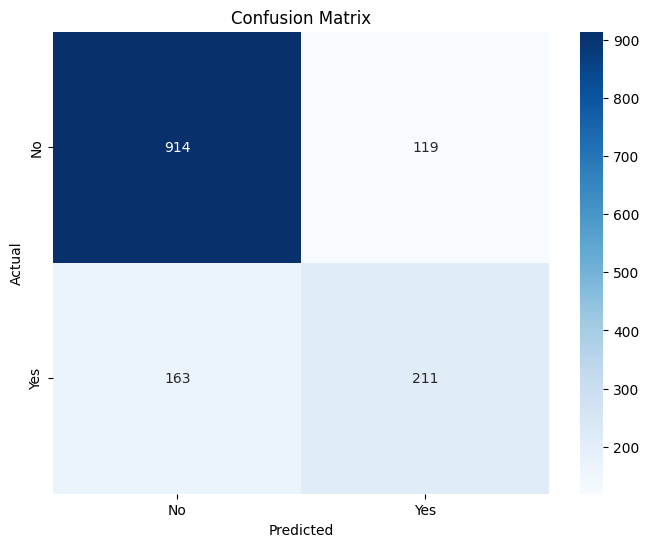

In [150]:
#Predicted classes
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

#Compute confusion matrix
cm=confusion_matrix(y_test,y_pred)

#Plot using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['No','Yes'],yticklabels=['No','Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


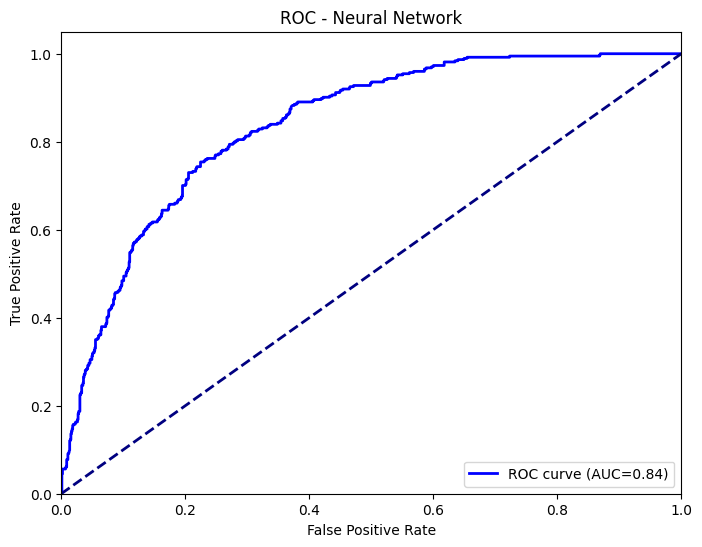

In [151]:
y_prob=best_model.predict(X_test).ravel()

#Compute ROC curve
fpr,tpr,thresholds=roc_curve(y_test,y_prob)

#Compute AUC
roc_auc=auc(fpr,tpr)

#plot diagram
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue',lw=2,label='ROC curve (AUC=%0.2f)' % roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Neural Network')
plt.legend(loc="lower right")
plt.show()